In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# plt.rcParams["font.family"] = "Arial"
# from skimage import measure
import pyvista as pv
# pv.set_jupyter_backend('static')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat, loadmat
from time import time
from PIL import Image
from scipy.interpolate import splrep, splev
# from numba import jit
from Vortex import *

In [2]:
# random seed
np.random.seed(1145141)

In [3]:
def sample_wave_dispersion(r_grid, k_mean, k_cov, t=0, f_omega=lambda x: 0, n_wave=100, kappa=1e8, seed=None):
    """
    Sample random wave

    This function generates the randomwave structure at given time step providing given wave dispersion function.

    Parameters:
    - r_grid (list of numpy arrays): The grid of positions where the wave is calculated.
    - k_mean (numpy array): The mean wave vector.
    - k_cov (numpy array): The covariance matrix of the wave vector.
    - t (float, optional): Time. Default is 0.
    - f_omega (function, optional): The function that calculates the angular frequency. Default is a constant function returning 0 (not traveling).
    - n_wave (int, optional): The number of waves to sample. Default is 100.
    - kappa (float, optional): The kappa parameter for the von Mises-Fisher orientation distribution. Default is 1e8.
    - seed (int, optional): The random seed for reproducibility. Default is None.

    Returns:
    - rho (numpy array): Randomwave.

    """
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    np.random.seed(seed)
    for i in range(n_wave):
        flip = 2*(i%2)-1
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        omega_t = f_omega(k_sample_rot)*t*flip
        phi_r = np.random.rand()*2*np.pi-np.pi # random phase
        rho_i = np.exp(1j*(k_dot_r + omega_t + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    # print(omega_t)
    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def scale_rho(rho, xyz, scale):
    rho = ndimage.zoom(rho, scale, order=1)
    # r_grid = np.array([ndimage.zoom(r, scale, order=1) for r in r_grid]) 
    x = xyz[0]
    y = xyz[1]
    z = xyz[2]
    x_zoom = ndimage.zoom(x, scale, order=1)
    y_zoom = ndimage.zoom(y, scale, order=1)
    z_zoom = ndimage.zoom(z, scale, order=1)
    r_grid = np.meshgrid(x_zoom,y_zoom,z_zoom)
    return rho, r_grid

In [4]:
def draw_from_hist(hist, bins, nsamples = 100000):
    cumsum = [0] + list(np.cumsum(hist))
    rand = np.random.rand(nsamples)*max(cumsum)
    return [np.interp(x, cumsum, bins) for x in rand]

def sample_wave_vect(k_mean, k_cov, f_omega=lambda x: 0, n_wave=100, kappa=1e8, seed=None):
    """
    Sample random wave

    This function generates the randomwave structure at given time step providing given wave dispersion function.

    Parameters:
    - r_grid (list of numpy arrays): The grid of positions where the wave is calculated.
    - k_mean (numpy array): The mean wave vector.
    - k_cov (numpy array): The covariance matrix of the wave vector.
    - t (float, optional): Time. Default is 0.
    - f_omega (function, optional): The function that calculates the angular frequency. Default is a constant function returning 0 (not traveling).
    - n_wave (int, optional): The number of waves to sample. Default is 100.
    - kappa (float, optional): The kappa parameter for the von Mises-Fisher orientation distribution. Default is 1e8.
    - seed (int, optional): The random seed for reproducibility. Default is None.

    Returns:
    - rho (numpy array): Randomwave.

    """
    np.random.seed(seed)
    
    phi_r_list = []
    k_sample_rot_list = []
    omega_list = []
    for i in range(n_wave):
        flip = 2*(i%2)-1
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample
        omega = f_omega(k_sample_rot)

        # compute randomwave
        phi_r = np.random.rand()*2*np.pi-np.pi # random phase
        phi_r_list.append(phi_r)
        k_sample_rot_list.append(k_sample_rot)
        omega_list.append(omega)
    
    return phi_r_list, k_sample_rot_list, omega_list

def sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, omega_list, t=0):
    # initialize randomwave 
    rho = np.zeros_like(r_grid[0]).astype('complex64')
    r_grid = [r.astype(np.float32) for r in r_grid]
    n_wave = len(phi_r_list)
    for i in range(n_wave):
        # compute randomwave
        k_sample_rot = k_sample_rot_list[i]
        phi_r = phi_r_list[i]
        omega = omega_list[i]
        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        
        rho_i = np.exp(1j*(k_dot_r + omega*t + phi_r)) # cos(k_n.r + phi_n)
        rho += rho_i.astype('complex64')

    rho = np.sqrt(2/n_wave)*rho
    
    return rho


In [5]:
## dispersion relation
def f_omega_deBroglie(k,D=1):
    k_norm = np.linalg.norm(k)
    return D*k_norm**2

def f_omega_em(k,c=1):
    k_norm = np.linalg.norm(k)
    return c*k_norm

def f_omega_dos(k,sigma=0.01):
    omega_list = np.arange(1000)/1000*2
    p_omega = np.exp(-(omega_list-1)**2/2/sigma**2)
    bins = np.arange(1001)/1000
    return draw_from_hist(p_omega,bins,nsamples=1)[0]

## Real space structure

### Collect snapshots

In [6]:
## Meshgrid
n_grid = 64-1
scale = 3
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

sigma_k_list = [0.001]
kappa_list = [64]

parameters_list = []
rho_list = []

k_bar = scale*2*np.pi

# t_list = np.linspace(0,10,501)/k_bar
t_list = np.linspace(0,1,101)*40*np.pi

for sigma_k in sigma_k_list:
    for kappa in kappa_list:
        ## Random wave
        # sigma_k = 0.025
        # kappa = 1
        alpha = 0

        parameters = [sigma_k,kappa,alpha]
        parameters_list.append(parameters)

        print('parameters = [{:0.2f}, {:0>3d}, {:0.2f}]'.format(*parameters))
        #### Wave vector distribution ####
        k_mean_z = np.array([0,0,scale])*2*np.pi # lamellar perpendicular to z axis 
        # k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
        k_var  = (np.array([0,0,sigma_k*scale])*2*np.pi)**2
        k_cov  = np.diagflat(k_var)
        
        phi_r_list, k_sample_rot_list, omega_list = sample_wave_vect(k_mean_z, k_cov, n_wave=50, kappa=kappa, seed=114514, f_omega=lambda x: f_omega_dos(x,sigma=0.2))
            
        rho_t = []
        for t in tqdm(t_list):
            
            # rho = sample_wave_dispersion(r_grid, k_mean_z, k_cov, t=t, f_omega=f_omega_em, n_wave = 50, kappa=kappa, seed=1145141)
            rho = sample_wave_time(r_grid, phi_r_list, k_sample_rot_list, omega_list, t=t)
            rho_t.append(rho) # append this timestep
            
        rho_list.append(rho_t)

parameters = [0.00, 064, 0.00]


  0%|          | 0/101 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:25<00:00,  4.01it/s]


## Time Correlation

In [7]:
def rearrange(F_q):
    ind_max = int(F_q.shape[0]/2)
    # beam stopper
    F_q[0,0,0] = (np.sum(F_q[0:2,0:2,0:2])-F_q[0,0,0])/7
    # rearrange FFT datapoints
    # rearrange x
    F_q_xpos = F_q[0:ind_max,:,:]
    F_q_xneg = F_q[ind_max:,:,:]
    F_q_x = np.concatenate((F_q_xneg,F_q_xpos),axis=0)
    # rearrange y
    F_q_ypos = F_q_x[:,0:ind_max,:]
    F_q_yneg = F_q_x[:,ind_max:,:]
    F_q_y = np.concatenate((F_q_yneg,F_q_ypos),axis=1)
    # rearrange z
    F_q_zpos = F_q_y[:,:,0:ind_max]
    F_q_zneg = F_q_y[:,:,ind_max:]
    F_q_z = np.concatenate((F_q_zneg,F_q_zpos),axis=2)
    return F_q_z

def rho_fft(rho_t, alpha=0):
    F_q_list = []
    for i_t, t in tqdm(enumerate(t_list)):
        rho = rho_t[i_t]
        
        N = (rho.shape[0]) ** 3  # Number of grid points after scaling
        
        rho_bi = np.zeros_like(rho)  # Density = 0 or 1
        rho_bi[rho > alpha] = 1  # Clipped to alpha
        
        F_q = np.fft.fftn(rho_bi)  # FFT of the grid density
        # F_q = np.fft.fftshift(F_q)
        F_q = rearrange(F_q)
        F_q_list.append(F_q)
    return F_q_list
    
def reduce_I_qt(F_q_list, n_grid_scale, t_list):
    f_qt = []
    I_qt = []
    N = n_grid_scale ** 3

    ind_max = int(n_grid_scale/2)
    q_grid = np.arange(n_grid_scale)
    q_grid = q_grid-ind_max
    qq_xyz = np.meshgrid(q_grid,q_grid,q_grid)

    n_qq = int(ind_max)
    qq = np.arange(n_qq)
    dq = qq[1]-qq[0]
    index_qq_xyz = np.floor(np.sqrt(qq_xyz[0]**2+qq_xyz[1]**2+qq_xyz[2]**2)/dq).astype(int).flatten()

    for i_dt in trange(len(t_list)-1):
        f_qti = np.zeros_like(F_q_list[0])
        for i_t0 in range(len(t_list)-i_dt-1):
            f_qti += F_q_list[i_t0]*np.conj(F_q_list[i_t0+i_dt])
        f_qti = f_qti/(len(t_list)-i_dt-1)/N
        
        f_qt.append(f_qti)
        
        I_qti = np.zeros_like(qq).astype(complex)
        n_q = np.zeros_like(qq)
        for i_f, f in enumerate(np.abs(f_qti).flatten()):
            index = index_qq_xyz[i_f]
            if index<n_qq:
                I_qti[index] += f
                n_q[index] += 1
        I_qti = I_qti/n_q
        I_qt.append(I_qti)

    I_qt = np.array(I_qt)
    return qq, I_qt
    

In [8]:
### FFT each frame
rho_t = rho_list[0]
n_grid_scale = 64

F_q_list = rho_fft(rho_t)
qq, I_qt = reduce_I_qt(F_q_list, n_grid_scale, t_list)

101it [00:00, 177.27it/s]
100%|██████████| 100/100 [00:10<00:00,  9.47it/s]


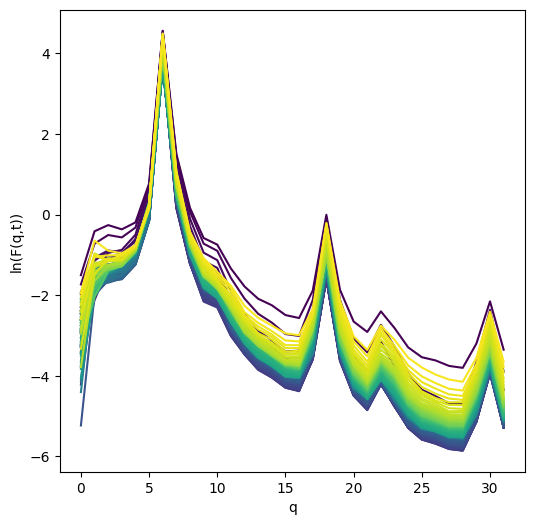

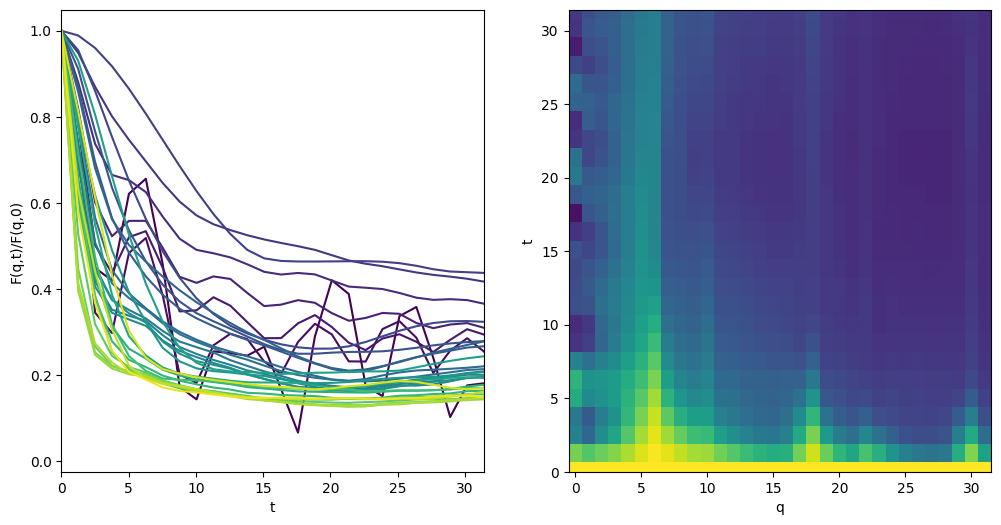

In [9]:
I_qt_real = np.real(I_qt)
cmap = matplotlib.colormaps["viridis"]
t_max = 10*np.pi

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 1, 1)

for i_t, t in enumerate(t_list[:-1]):
    ax.plot(qq,np.log(I_qt_real[i_t,:]),color = cmap(i_t/len(t_list[:-1])))

ax.set_xlabel("q")
ax.set_ylabel("ln(F(q,t))")

t_plot, q_plot = np.meshgrid(qq, t_list[:-1])


fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)

for i_q, q in enumerate(qq):
    ax.plot(t_list[:-1],I_qt_real[:,i_q]/I_qt_real[0,i_q],color = cmap(i_q/len(qq)))

ax.set_xlim([0,t_max])
ax.set_xlabel("t")
ax.set_ylabel("F(q,t)/F(q,0)")

# fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(1, 2, 2)
ax.pcolormesh(t_plot, q_plot, ((I_qt_real/I_qt_real[0,:])))

ax.set_ylim([0,t_max])
ax.set_xlabel("q")
ax.set_ylabel("t")


plt.show()